In [1]:
from __future__ import annotations

import random
from typing import Any

import numpy as np
from gym import Env
from gym.spaces import Box
from gym.spaces import Discrete
from numpy.typing import NDArray

import numpy as np
import matplotlib.pyplot as plt

# Planning

## Task List
- Drill multiple wells, one after the other and not to update the environment after every simulation.
- Make sure well/wells dont crash into each other/itself or any faults/artifacts 
- Have a target zone where the well eventually want to make it to and get higher reward
- Use a metric like MSE/UCS to get an estimate on the amount of energy required to drill and optimizing it to have lowest energy usage (also tie in the economic constraints)

## Action Space
- Surface Location ?? Pick it randomly or intentionally?
- Number of wells to drill
- Bit Movement
    -  Up
    -  Down
    -  Left
    -  Right
    -  Angle ?? If the grid size is as much as a stand then the max angle should be around 3 degrees 

## Observation Space

Same shape [matrix] as the input. Ideally 30 ft by 30 ft to match with the drilling pipe (90 ft by 90 ft for stand). Bool with true for wherever well is located.

## Possible Rewards
- While Drilling
    -  Proximity to Reservoir (based on the percentage of Normalized TOC?) - *Positive Reward*
    -  Proximity to Fault - *VERY HIGH Negative Reward*
    -  Proximity to itself or other wells - *VERY HIGH Negative Reward*
    -  Proximity to the possible depletion zone of an existing well - *VERY HIGH Negative Reward*
    -  Remaining oil in the zone of the well - *High Positive Reward*

- After Drilling
    -  Total UCS/MSE it was drilled through - *Negative Reward based on the UCS total, can also relate it to a USD amount*    
    -  Total Well Length - *Negative Reward based on the pipe count, can also relate it to a USD amount* 

# Starter Notebook

In [4]:
class SimpleDriller(Env):  # type: ignore
    """Simple driller environment."""

    def __init__(self, env_config: dict[str, Any]) -> None:
        """Initialize environment with config dictionary."""
        self.model = np.loadtxt(
            env_config["model_path"],
            delimiter=env_config["delim"],
        )

        self.nrow, self.ncol = self.model.shape
        self.available_pipe = env_config["available_pipe"]

        self.production = 0
        self.pipe_used = 0
        self.trajectory: list[list[int]] = []
        self.bit_location: list[int] = []

        self.action_space = Discrete(4)

        self.observation_space = Box(
            low=0, high=1, shape=(self.nrow, self.ncol), dtype="bool"
        )
        self.reset()

    def step(self, action: int) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        done = False
        actions = {
            0: [1, 0],  # down
            1: [0, -1],  # left
            2: [0, 1],  # right
            3: [-1, 0],  # up
        }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            reward = -100

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            reward = -100

        else:
            reward = self.model[newrow, newcol] + self.pipe_used / 2
            self.update_state()

        if self.pipe_used == self.available_pipe:
            done = True
            reward = 0

        if self.bit_location in self.trajectory[:-1]:
            done = True
            reward = -100

        info: dict[str, Any] = {}

        return self.state, reward, done, info

    def update_state(self) -> None:
        """Update state method."""
        traj_i, traj_j = np.asarray(self.trajectory).T
        self.state[traj_i, traj_j] = 1

    def render(self) -> None:
        """Gym environment rendering."""
        raise NotImplementedError("No renderer implemented yet.")

    def reset(self) -> NDArray[np.bool_]:
        """Reset the status of the environment."""
        self.surface_hole_location = [1, random.randint(0, self.ncol - 1)]  # noqa: S311
        self.state = np.zeros((self.nrow, self.ncol), dtype=bool)
        self.bit_location = self.surface_hole_location
        self.trajectory = [self.surface_hole_location]
        self.pipe_used = 0
        return self.state


Beginning Drill Campaign: 1


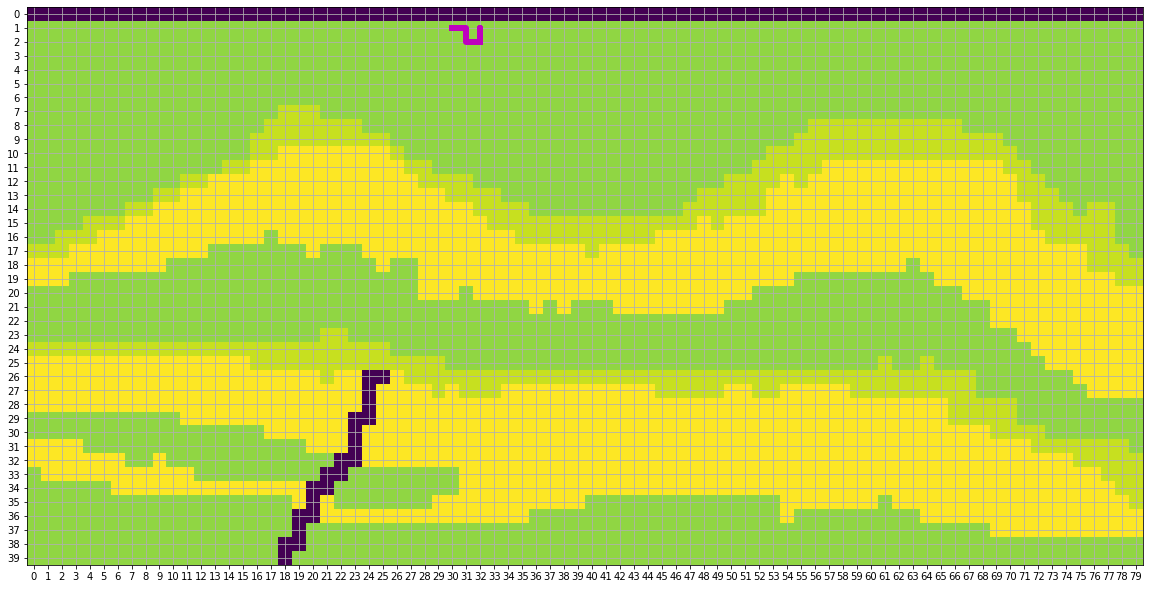

In [5]:
env_config = dict(model_path=r"data/2d_stacked.csv", available_pipe=50, delim=",")

env = SimpleDriller(env_config)

episodes = 1
for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
    score = 0

    while not done:
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        score += reward

# This comes in as [[row1, col1], ..., [rowN, colN]]
# Once we unpack it its z, then x.
traj_z, traj_x = np.asarray(env.trajectory).T

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.plot(traj_x, traj_z, "-", c="m", linewidth=6)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.xlim([-0.5, 79.5])
plt.ylim([39.5, -0.5])
plt.grid()

In [8]:
from stable_baselines3 import PPO

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50_000, log_interval=10)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\venkatasai.poludasu\Anaconda3\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.1        |
|    ep_rew_mean          | 144         |
| time/                   |             |
|    fps                  | 1034        |
|    iterations           | 10          |
|    time_elapsed         | 19          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.007318277 |
|    clip_fraction        | 0.0612      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.601      |
|    explained_variance   | 0.0983      |
|    learning_rate        | 0.0003      |
|    loss                 | 4.01e+03    |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0143     |
|    value_loss           | 9.56e+03    |
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 37.4

Beginning Drill Campaign: 1


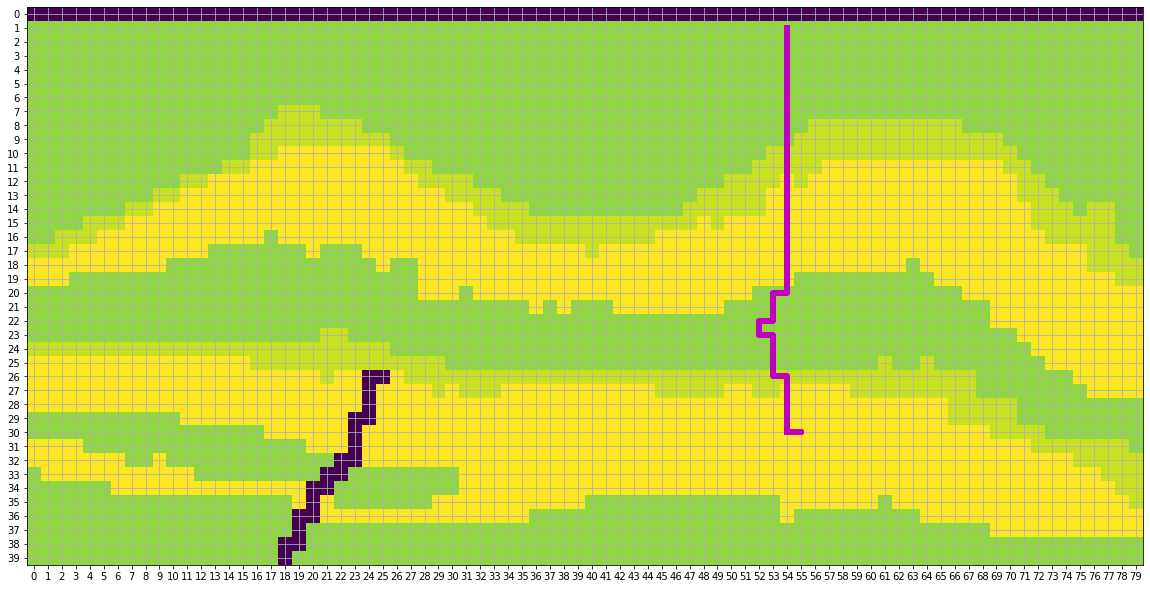

In [9]:
env = SimpleDriller(env_config)

episodes = 1
for episode in range(1, episodes + 1):
    print("Beginning Drill Campaign:", episode)
    state = env.reset()
    done = False
    score = 0

    while not done:
        action, _states = model.predict(state)
        state, reward, done, info = env.step(action)
        score += reward

# This comes in as [[row1, col1], ..., [rowN, colN]]
# Once we unpack it its z, then x.
traj_z, traj_x = np.asarray(env.trajectory).T

plt.figure(figsize=(20, 20))
plt.imshow(env.model, vmin=-10, vmax=2)
plt.plot(traj_x, traj_z, "-", c="m", linewidth=6)
plt.xticks(np.arange(0, 80, 1.0))
plt.yticks(np.arange(0, 40, 1.0))
plt.xlim([-0.5, 79.5])
plt.ylim([39.5, -0.5])
plt.grid()

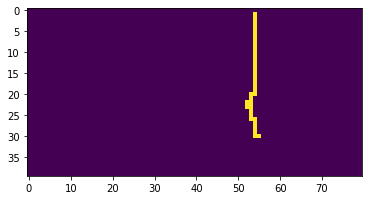

In [10]:
plt.imshow(env.state)

In [ ]:
def step(  # noqa: C901
        self, action: int
    ) -> tuple[NDArray[np.bool_], int, bool, dict[str, Any]]:
        """Take step based on action."""
        done = False
        actions = {
            0: [1, 0],  # down
            1: [0, -1],  # left
            2: [0, 1],  # right
            3: [-1, 0],  # up
        }

        dz_dx = actions[action]
        new_location = [prev + now for prev, now in zip(self.bit_location, dz_dx)]

        self.bit_location = new_location

        self.trajectory.append(new_location)
        newrow, newcol = new_location

        self.pipe_used += 1

        if newrow < 1 or newrow >= self.nrow:
            done = True
            reward = -100

        elif newcol < 0 or newcol >= self.ncol:
            done = True
            reward = -100

        else:
            reward = self.model[newrow, newcol] + self.pipe_used / 2
            self.update_state()

        if self.pipe_used == self.available_pipe:
            done = True
            reward = 0

        if self.bit_location in self.trajectory[:-1]:
            done = True
            reward = -100

        info: dict[str, Any] = {}

        return self.state, reward, done, info
